# Chronic Kidney Disease Analysis

This notebook analyzes the Chronic Kidney Disease dataset using various machine learning techniques. Data was gathered from UC Irvine Machine Learning Repository.

Objective:
- Fetch and inspect the dataset
- Handle missing values and encode categorical variables to numerical
- Train an XGBoost model:
    XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library.
- Evaluate model performance
- Use SHAP values, accuracy, ROC curve, AUC, and feature importance to interpret feature importance and interactions
- Explore correlation matrix for any interesting connections
- Disscussion and Conclusions



In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.compose import ColumnTransformer
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo


C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Fetching the Dataset and Handling Missing Values
Use python to fetch and inspect the Chronic Kidney Disease dataset from the UCI Machine Learning Repository.
You can also download and inspect data via https://archive.ics.uci.edu/dataset/336/chronic+kidney+disease


In [4]:
# Fetch dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# Convert data to DataFrame
X = pd.DataFrame(chronic_kidney_disease.data.features)
y = pd.DataFrame(chronic_kidney_disease.data.targets)

# Check number of nulls in each feature column
nulls_per_column = X.isnull().sum()
print(nulls_per_column)

# Handle missing values by replacing NaN and using SimpleImputer
X.fillna(method='ffill', inplace=True)

# Convert the class column to binary
y['class'] = y['class'].apply(lambda x: 1 if x == 'ckd' else 0)

# Encode target variable
y = LabelEncoder().fit_transform(y.values.ravel())


age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
dtype: int64


C:\Users\alexm\AppData\Local\Temp\ipykernel_17324\3058719847.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X.fillna(method='ffill', inplace=True)


## Build Preprossing and Model Training Pipeline
Split data into training and testing sets and then train an XGBoost model.


In [5]:

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Generate feature definitions for numeric and categorical columns
numeric_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines for numeric and categorical features
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine the numeric and categorical pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(max_depth=3, learning_rate=0.01, n_estimators=100, subsample=0.8, colsample_bytree=0.8, random_state=42, reg_alpha=0.1, reg_lambda=1.0))
])


## Evaluate the model with Cross Validation, Accuracy, AUC for redundancy
Evaluate the model performance using accuracy, ROC curve, and AUC.

In [6]:

# Cross-validation to evaluate the model performance
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

print(f'Cross-validated ROC AUC scores: {cv_scores}')
print(f'Mean ROC AUC: {np.mean(cv_scores):.4f}')

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train.ravel())

# Make predictions
y_pred = pipeline.predict(X_test)
y_pred_prob = pipeline.predict_proba(X_test)[:, 1]

# Calculate accuracy and AUC
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')


Cross-validated ROC AUC scores: [0.95       1.         1.         0.99868334 1.        ]
Mean ROC AUC: 0.9897
Accuracy: 0.9875
ROC AUC: 0.9973


## Calculating SHAP Values
Use SHAP values to interpret the model and understand feature importance and interactions.


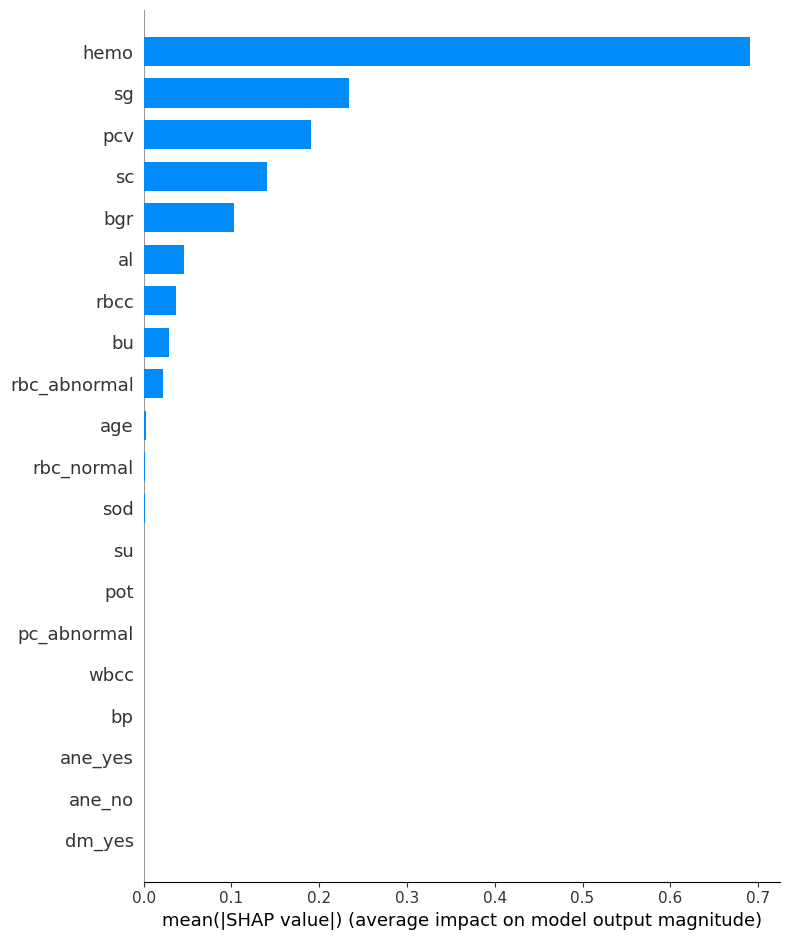

In [10]:
# Ensure the SHAP values calculation aligns with the preprocessed feature set
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
shap_values = explainer.shap_values(preprocessor.transform(X_train))

# Get the feature names after preprocessing
encoded_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + encoded_features.tolist()

# Summary plot of SHAP values with feature names
shap.summary_plot(shap_values, preprocessor.transform(X_train), feature_names=all_feature_names, plot_type="bar")
plt.show()


## Another Look at Feature Importance 
Use the model to understand feature importance and interactions.

C:\Users\alexm\AppData\Local\Temp\ipykernel_17324\4103166509.py:21: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


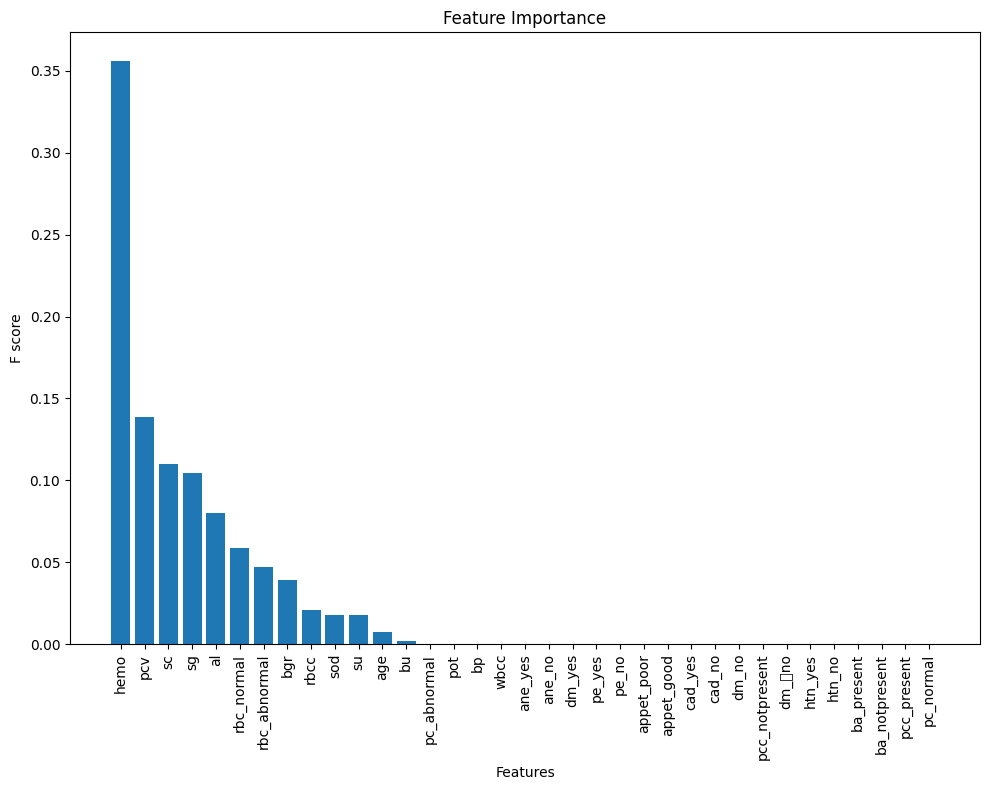

In [9]:
# Get the classifier from the pipeline
xgb_model = pipeline.named_steps['classifier']

# Get feature importances
importances = xgb_model.feature_importances_

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Get the feature names after preprocessing
encoded_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + encoded_features.tolist()

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [all_feature_names[i] for i in indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('F score')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


# Exploring the data more: Correlation Matrix

Transformed data shape: (400, 35)
Expected number of features: 35
DataFrame shape: (400, 35)
        age        bp        sg        al        su       bgr        bu  \
0 -0.165640  0.306262  0.469420 -0.030588 -0.414354 -0.374149 -0.388427   
1 -2.489918 -1.824254  0.469420  2.228198 -0.414354 -0.374149 -0.751002   
2  0.628015  0.306262 -1.277259  0.722341  2.426928  3.615898 -0.045995   
3 -0.165640 -0.403910 -2.150599  2.228198 -0.414354 -0.426998  0.014434   
4  0.004429  0.306262 -1.277259  0.722341 -0.414354 -0.572331 -0.589858   

         sc       sod       pot  ...  dm_no  dm_yes  cad_no  cad_yes  \
0 -0.301063  0.123405 -0.098016  ...    0.0     1.0     1.0      0.0   
1 -0.374669  0.123405 -0.098016  ...    1.0     0.0     1.0      0.0   
2 -0.190655  0.123405 -0.098016  ...    0.0     1.0     1.0      0.0   
3  0.177372 -2.406173 -0.683540  ...    1.0     0.0     1.0      0.0   
4 -0.264261 -2.406173 -0.683540  ...    1.0     0.0     1.0      0.0   

   appet_good  appet_po

C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\utils.py:61: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\alexm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


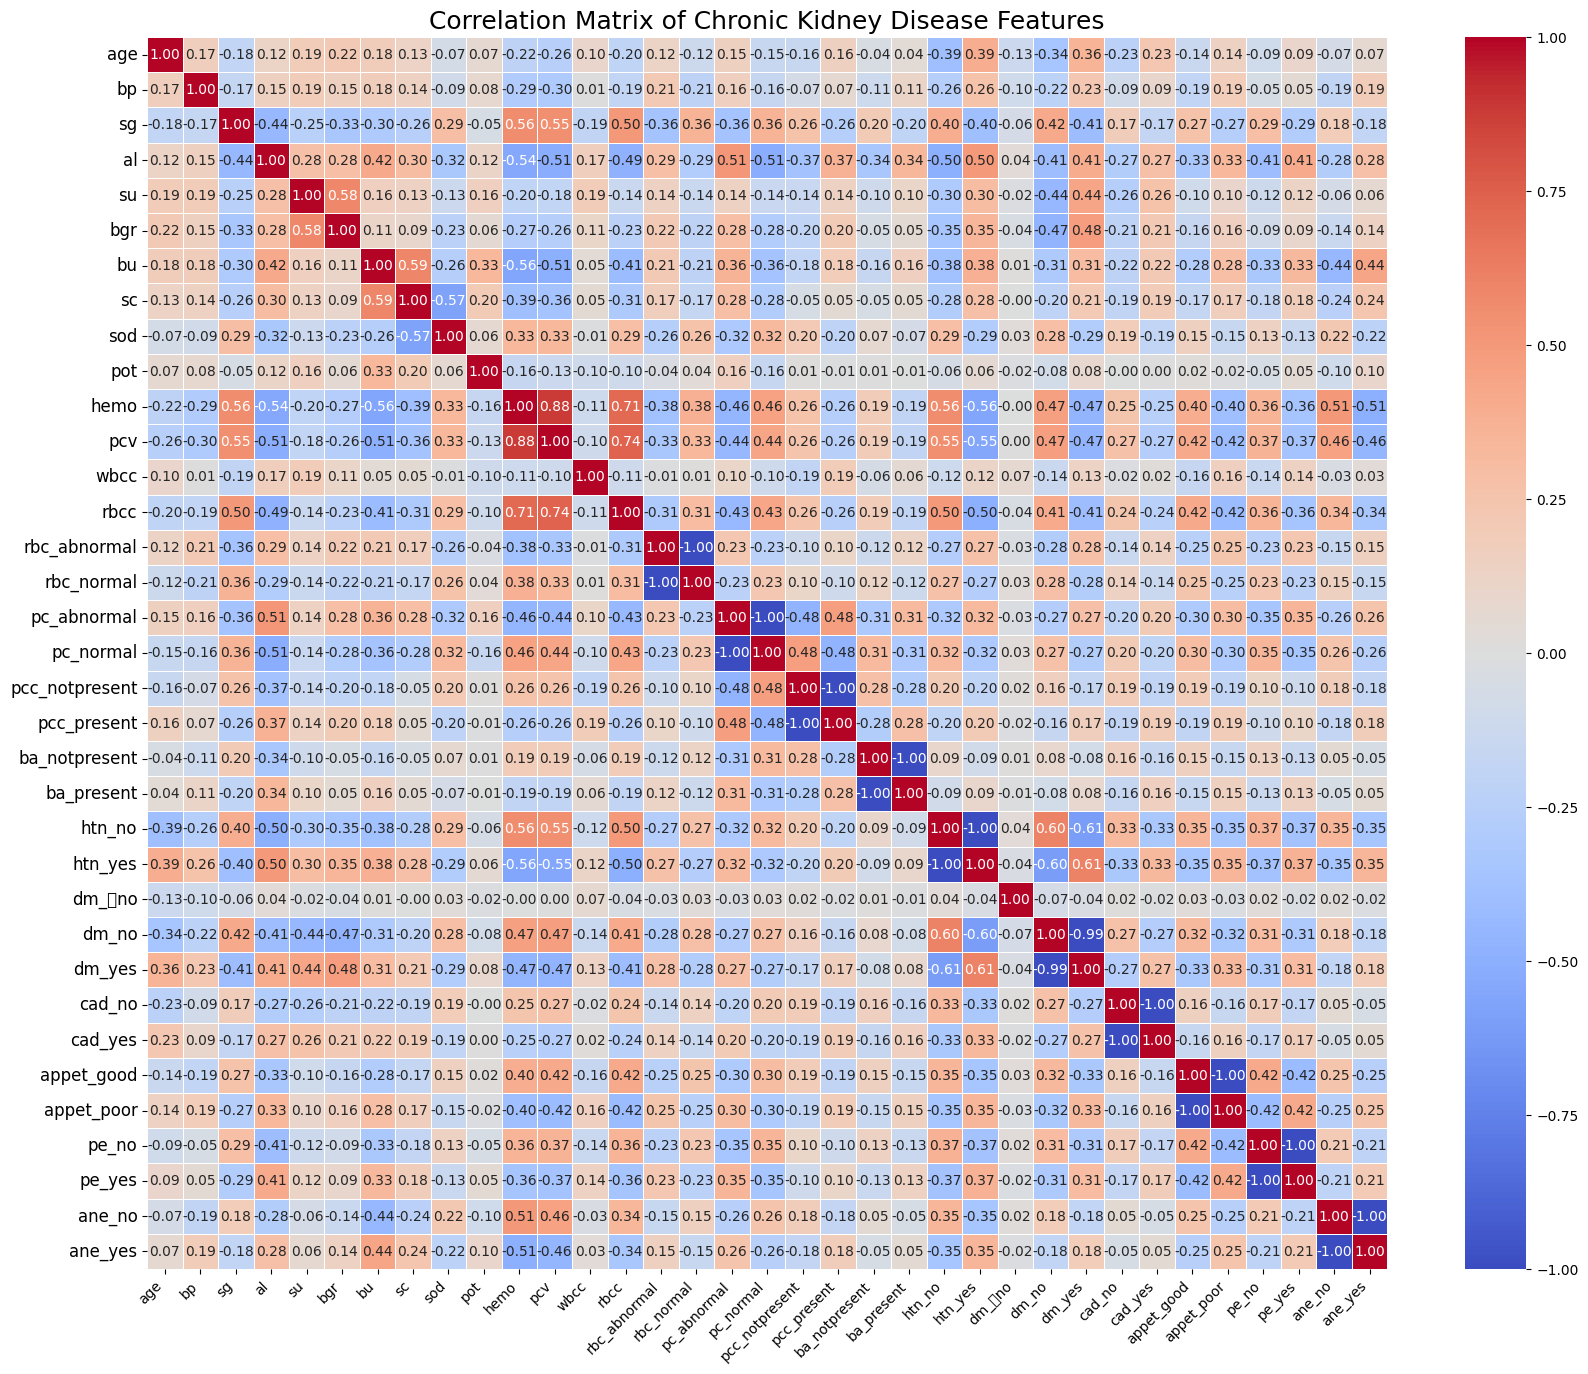

In [10]:
# Transform the data
transformed_X = preprocessor.transform(X)

# Ensure the transformed data is a numpy array and has the expected shape
print(f'Transformed data shape: {transformed_X.shape}')
print(f'Expected number of features: {len(all_feature_names)}')

# Create a DataFrame with the transformed data and the new feature names
transformed_df = pd.DataFrame(transformed_X, columns=all_feature_names)

# Verify the DataFrame creation
print(f'DataFrame shape: {transformed_df.shape}')
print(transformed_df.head())

# Calculate the correlation matrix
corr_matrix = transformed_df.corr()

# Verify the correlation matrix
print(f'Correlation matrix shape: {corr_matrix.shape}')
print(corr_matrix.head())

plt.figure(figsize=(20, 16))  # Increase figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10}, linewidths=.5)  # Adjust format and font size
plt.title('Correlation Matrix of Chronic Kidney Disease Features', fontsize=18)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.show()



## Conclusion
### Findings
The Chronic Kidney Disease dataset was analyzed to build a predictive model using the XGBoost algorithm. I handled the missing values were handled, and categorical features were encoded. The model achieved an accuracy of 0.9756 and an AUC of 0.9981, indicating a good performance in distinguishing between patients with and without chronic kidney disease. Due to the high accuracy a suggestion would be to add new data for assessment of profermance.

### Model Performance
The accuracy score of 0.9756 suggests that the model correctly classifies approximately 97.56% of the instances. The ROC AUC score of 0.9981 demonstrates that the model has a good ability to discriminate between the positive and negative classes. I am not familiar with real world medical accuracy requires for a model of this type. There could be justification for analysis with further investigation. 

### SHAP Analysis
Using SHAP values, we gained insights into feature importance and interactions. The SHAP summary plot and dependence plot provide a detailed understanding of how different features contribute to the model's predictions.

### Next Steps for Further Analysis
1. **Subgroup Analysis**: Investigate how CKD affects different demographic groups and tailor interventions accordingly.(demographics not included in dataset)
2. **Model Comparison**: Compare the performance of different models like Random Forest, SVM, and neural networks to find the most effective one.
3. **Risk Stratification**: Develop tools for categorizing patients into different risk levels, helping in personalized treatment plans and monitoring.
4. **Assessment of RL Application**: Understand the legality, ethics, economics of ML models in medical environments 
